# LangGraph:  Agent Orchestration

#### By Pedro Izquierdo Lehmann

Welcome back! This last notebook is the second part of the LangChain notebook. We will explore the **LangGraph** library, which is built on top of LangChain, and is useful for the controlled design of complex workflows with or without loops, encompassing **agents orchestration**.

Also, we will not use the openAI API, but we will query locally stored LLMs using Ollama.

---
## (0. Environment Setup)

Before starting, set up a Python virtual environment and install required dependencies.

#### 1. Create a Virtual Environment

```bash
python3 -m venv lang-graph
```

#### 2. Activate the Virtual Environment

**On macOS/Linux:**
```bash
source lang-graph/bin/activate
```

**On Windows:**
```bash
lang-graph\Scripts\activate
```

#### 3. Install Required Dependencies

```bash
pip install langchain langgraph langchain-ollama jupyter ipykernel
```

Install Ollama (required for local LLMs):

```bash
# macOS (Homebrew)
brew install ollama
brew services start ollama

# Linux
curl -fsSL https://ollama.com/install.sh | sh

# Windows: download the installer
# https://ollama.com/download
```

#### 4. Register the Kernel

```bash
python -m ipykernel install --user --name=lang-graph --display-name "Python (lang-graph)"
```

#### 5. Start Jupyter

```bash
jupyter notebook
```

#### 6. Deactivate

```bash
deactivate
```

In [ ]:
# python3 -m venv lang-graph
# source lang-graph/bin/activate
# lang-graph\Scripts\activate
# pip install langchain langgraph langchain-ollama jupyter ipykernel

In [ ]:
# Install Ollama (required for local LLMs)
# macOS (Homebrew): brew install ollama
#                   brew services start ollama
# Linux: curl -fsSL https://ollama.com/install.sh | sh
# Windows: https://ollama.com/download

In [ ]:
# python -m ipykernel install --user --name=lang-graph --display-name "Python (lang-graph)"
# jupyter notebook
# deactivate

#### Ollama Setup

All model calls in this notebook must run **locally** via Ollama.

1. Start the Ollama server (separate terminal if needed)
2. Pull a local model (you can change the model name later)
3. Verify that Ollama can list your models

Run the code cell below in order.

In [13]:
# Check that Ollama is installed and running
! "C:\Users\happy\AppData\Local\Programs\Ollama\ollama.exe" --version
import os
os.environ["PATH"] += r";C:\Users\happy\AppData\Local\Programs\Ollama"
!ollama --version
!ollama list

# Pull a local model (edit if you want a different one)
OLLAMA_MODEL = "llama3.1"
!ollama pull {OLLAMA_MODEL}

# If Ollama is not running, start it in a separate terminal:
#!ollama serve

ollama version is 0.14.1
ollama version is 0.14.1
NAME    ID    SIZE    MODIFIED 


pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 鉅� pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻� 351 KB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻� 3.2 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻� 6.9 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻� 8.7 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻�  12 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻�  16 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻�  18 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc:   0% 鈻�                  鈻�  20 MB/4.9 GB                  pulling 

In [14]:
from typing import TypedDict, Annotated, Literal
from dataclasses import dataclass, field
import operator
import math

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, BaseMessage
from langchain_core.tools import tool
from langchain.agents import create_agent

from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import InMemorySaver

from ollama import chat
from ollama import ChatResponse

In [15]:
response: ChatResponse = chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Please discuss the conversion of Phillips 66 from oil to renewable diesel.',
  },
])
print(response.message.content)

Phillips 66, a leading refining and chemicals company in the United States, has made significant strides in transitioning its business model towards the production of renewable diesel, a low-carbon alternative to traditional fossil fuels.

**Background:**
In response to the growing demand for cleaner-burning transportation fuels and increasing regulatory pressures on greenhouse gas emissions, Phillips 66 began exploring opportunities to diversify its portfolio and reduce its carbon footprint. The company saw potential in the rapidly expanding market for renewable diesel, which is produced from non-petroleum feedstocks such as agricultural waste, algae, or other organic materials.

**Conversion strategy:**
In 2018, Phillips 66 announced plans to convert its existing Sweeny Refinery in Texas into a renewable diesel production facility. The $1 billion project aimed to transform the refinery's hydrotreating unit, which previously processed fossil fuels, into a platform for producing renewa

In [ ]:
# LLM (local via Ollama)
OLLAMA_MODEL = "llama3.1"
llm = ChatOllama(model=OLLAMA_MODEL, temperature=0)

---

## 1. Graphs for Agentic AI

LangChain gives you **tools** and **agents**, but the control flow still lives inside the LLM loop; the default ReAct pattern is sufficient. Effectively, the chains of LangChain are directed acyclic graphs (DAGs), where 

- **Nodes** are explicit steps (LLM calls or Python logic)
- **Edges** define how control flows between steps
- **State** is a typed object that persists across the graph. 

> **Note**: The graph state is the central, typed data structure that flows through nodes and is mutated by each node. It’s the single source of truth for the workflow at any step (messages, intermediate results, flags, etc.). Every node reads from it and returns partial updates to it.

> **Keep in mind**: The graph state, `ToolRuntime`, and `InMemorySaver` all relate to “runtime context,” but they operate at different layers.
>- The LangGraph state is the _actual working state_ your nodes read/write.
>- `ToolRuntime` is a _tool-level context injection_ (useful for user/session info), not a state container.
>- `InMemorySaver` is _storage_ so state can be resumed later; it does not define state, it just saves it.

With LangGraph one can construct explicitly a **graph** workflow that may have **cycles**, allowing for more workflow expressivity. Also, it provides conditional routing along the graph; much more control over the workflow is possible.



The following is an example of an agentic workflow graph. Notice how we **separate reasoning from deterministic checks**, which is hard to guarantee with a pure agent loop.

In [17]:
# This graph receives financial macros in text and the returns of an asset, then it summarizes the text and computes the volatility of the asset, and then it provides a one-sentence implication for a long-only equity portfolio.
# Graph: summarize macro -> compute volatility -> final brief (linear DAG)
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0.2,
)

macro_headlines = [
    "CPI comes in below expectations; core inflation cools",
    "Fed signals pause; markets price in two cuts",
    "Oil spikes on supply concerns",
]

returns = [0.002, -0.004, 0.001, 0.003, -0.002, 0.0005, -0.001]

class MacroState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    macro_summary: str
    realized_vol: float
    risk_bucket: str


def summarize_macro(state: MacroState):
    prompt = (
        "Summarize these headlines into a 2-sentence macro brief for an equity analyst:\n"
        + "\n".join(f"- {h}" for h in macro_headlines)
    )
    response = llm.invoke([SystemMessage(content=prompt)])
    return {"messages": [response], "macro_summary": response.content}


def compute_vol(state: MacroState):
    daily_vol = math.sqrt(sum(r * r for r in returns) / len(returns))
    annualized = daily_vol * math.sqrt(252)
    if annualized < 0.15:
        bucket = "LOW"
    elif annualized < 0.25:
        bucket = "MEDIUM"
    else:
        bucket = "HIGH"
    return {"realized_vol": annualized, "risk_bucket": bucket}


def final_brief(state: MacroState):
    content = (
        f"Macro brief: {state['macro_summary']}\n"
        f"Risk overlay: realized vol {state['realized_vol']:.2%} -> {state['risk_bucket']} risk.\n"
        "Provide a one-sentence implication for a long-only equity portfolio."
    )
    response = llm.invoke([HumanMessage(content=content)])
    return {"messages": [response]}


builder = StateGraph(MacroState)
builder.add_node("summarize_macro", summarize_macro)
builder.add_node("compute_vol", compute_vol)
builder.add_node("final_brief", final_brief)

builder.add_edge(START, "summarize_macro")
builder.add_edge("summarize_macro", "compute_vol")
builder.add_edge("compute_vol", "final_brief")
builder.add_edge("final_brief", END)

macro_graph = builder.compile()

result = macro_graph.invoke({"messages": []})
print(result["messages"][-1].content)

The low realized volatility suggests that the market may be due for a correction, implying that investors in a long-only equity portfolio should consider reducing exposure or maintaining a cautious stance to mitigate potential losses.


If you want to visualize the graph structure:

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	summarize_macro(summarize_macro)
	compute_vol(compute_vol)
	final_brief(final_brief)
	__end__([<p>__end__</p>]):::last
	__start__ --> summarize_macro;
	compute_vol --> final_brief;
	summarize_macro --> compute_vol;
	final_brief --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



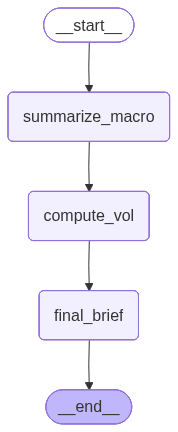

In [18]:
from IPython.display import Image, display

# Mermaid text diagram (paste into a Mermaid renderer if needed)
print(macro_graph.get_graph().draw_mermaid())
display(Image(macro_graph.get_graph().draw_mermaid_png()))

### Exercise 1: Add a Position Sizing Node

Example above uses a three-step flow: summarize macro, compute volatility, and final brief. Now add a **position sizing** node that sets a target exposure based on the risk bucket:

- LOW -> 1.0
- MEDIUM -> 0.6
- HIGH -> 0.3

Then include the target exposure in the final response.

In [24]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage

# Define the state with target_exposure
class MacroState2(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    macro_summary: str
    realized_vol: float
    risk_bucket: str
    target_exposure: float

# 1. Create a node `position_size(state)` that returns target_exposure
def position_size(state: MacroState2):
    if state["risk_bucket"] == "LOW":
        exposure = 1.0
    elif state["risk_bucket"] == "MEDIUM":
        exposure = 0.6
    else:
        exposure = 0.3
    return {"target_exposure": exposure}

# 2. Update final_brief to include target_exposure
def final_brief(state: MacroState2):
    content = (
        f"Macro brief: {state['macro_summary']}\n"
        f"Risk overlay: realized vol {state['realized_vol']:.2%} -> {state['risk_bucket']} risk.\n"
        f"Target exposure: {state['target_exposure']:.0%} of NAV.\n"
        "Provide a one-sentence implication for a long-only equity portfolio."
    )
    # Invoke the LLM with the formatted prompt
    response = llm.invoke([HumanMessage(content=content)])
    return {"messages": [response]}

# 3. Build and run the graph with the new node
builder2 = StateGraph(MacroState2)

# Add all nodes
builder2.add_node("summarize_macro", summarize_macro)
builder2.add_node("compute_vol", compute_vol)
builder2.add_node("position_size", position_size) # New Node
builder2.add_node("final_brief", final_brief)     # Updated Node

# Define the sequential edges
builder2.add_edge(START, "summarize_macro")
builder2.add_edge("summarize_macro", "compute_vol")
builder2.add_edge("compute_vol", "position_size") # Connect to new node
builder2.add_edge("position_size", "final_brief") # Connect to final brief
builder2.add_edge("final_brief", END)

# Compile and run
macro_graph2 = builder2.compile()

out = macro_graph2.invoke({"messages": []})
print(out["messages"][-1].content)


The current market conditions suggest a low-risk environment, allowing the portfolio to maintain its full target exposure of 100% of Net Asset Value (NAV).


## 2. Streaming

LangGraph supports streaming, allowing you to see agent responses in real-time as they're generated. This is essential for building responsive user interfaces.

Below is a simple example that streams node updates as the graph executes. This is especially useful in finance dashboards where you want to show partial progress as each step completes.

In [25]:
# We will use the same macro_graph as before

def print_updates(event: dict):
    for node, update in event.items():
        if isinstance(update, dict) and update.get("messages"):
            print(f"[{node}] {update['messages'][-1].content}")
        else:
            print(f"[{node}] {update}")


for event in macro_graph.stream({"messages": []}, stream_mode="updates"):
    print_updates(event)

[summarize_macro] 
[compute_vol] {'realized_vol': 0.03562302626111375, 'risk_bucket': 'LOW'}
[final_brief] The low realized volatility suggests that the market may be due for a correction, implying that investors in a long-only equity portfolio should consider reducing exposure or being more cautious with new allocations.


## 3. Conditional Routing (Risk Gates)

LangGraph lets you **route** based on state. This is a major difference from LangChain's agent loop, because the control flow is explicit and testable.

We will route to a hedge node only when volatility is high.

In [26]:
# This graph computes realized volatility and uses it as a risk gate to decide whether to propose a hedge or skip hedging.
# Graph: compute vol -> route to hedge or skip (conditional gate)
class HedgeState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    realized_vol: float
    hedge_action: str


def compute_vol_only(state: HedgeState):
    daily_vol = math.sqrt(sum(r * r for r in returns) / len(returns))
    annualized = daily_vol * math.sqrt(252)
    return {"realized_vol": annualized}


def propose_hedge(state: HedgeState):
    action = f"Buy 1-month put spread; realized vol {state['realized_vol']:.2%}."
    return {"hedge_action": action}


def skip_hedge(state: HedgeState):
    return {"hedge_action": "No hedge needed."}


def hedge_router(state: HedgeState) -> Literal["propose_hedge", "skip_hedge"]:
    return "propose_hedge" if state["realized_vol"] > 0.25 else "skip_hedge"


hedge_builder = StateGraph(HedgeState)
hedge_builder.add_node("compute_vol", compute_vol_only)
hedge_builder.add_node("propose_hedge", propose_hedge)
hedge_builder.add_node("skip_hedge", skip_hedge)

hedge_builder.add_edge(START, "compute_vol")
hedge_builder.add_conditional_edges("compute_vol", hedge_router)
hedge_builder.add_edge("propose_hedge", END)
hedge_builder.add_edge("skip_hedge", END)

hedge_graph = hedge_builder.compile()

hedge_result = hedge_graph.invoke({"messages": []})
print(hedge_result["hedge_action"])

No hedge needed.


### Exercise 2: Add a Second Risk Gate

Example above uses a volatility gate. Now you have to build a graph with **drawdown gate** that routes to a reduce exposure step if the max drawdown exceeds 6%.

Keep exposure at current level; drawdown 4.46% is acceptable.


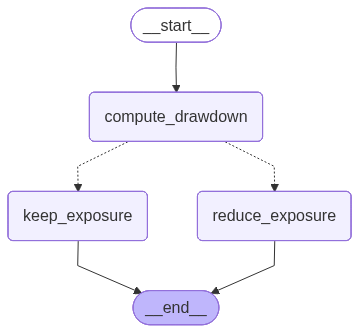

In [27]:
# EXERCISE: Add a drawdown gate
# 1. Compute max drawdown from returns
# 2. Create a node reduce_exposure
# 3. Route to reduce_exposure when drawdown > 6%

returns_ex2 = [0.01, -0.02, 0.005, -0.03, 0.015, -0.01, 0.004]

class GateState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    max_drawdown: float
    action: str

# TODO: implement max drawdown calculation
def compute_drawdown(state: GateState):
    equity = 1
    peak = 1
    max_dd = 0
    for r in returns_ex2:
        equity *= (1 + r)
        peak = max(peak, equity)
        dd = (peak - equity) / peak
        max_dd = max(max_dd, dd)
    return {"max_drawdown": max_dd}

def drawdown_router(state: GateState) -> Literal["reduce_exposure", "keep_exposure"]:
    return "reduce_exposure" if state["max_drawdown"] > 0.06 else "keep_exposure"

# TODO: implement reduce_exposure
def reduce_exposure(state: GateState):
    return {"action": f"Reduce exposure by 30% due to drawdown {state['max_drawdown']:.2%}"}

# TODO: implement keep_exposure
def keep_exposure(state: GateState):
    return {"action": f"Keep exposure at current level; drawdown {state['max_drawdown']:.2%} is acceptable."}

# TODO: implement router and graph
gate_builder = StateGraph(GateState)
gate_builder.add_node("compute_drawdown", compute_drawdown)
gate_builder.add_node("reduce_exposure", reduce_exposure)
gate_builder.add_node("keep_exposure", keep_exposure)

gate_builder.add_edge(START, "compute_drawdown")
gate_builder.add_conditional_edges("compute_drawdown", drawdown_router)
gate_builder.add_edge("reduce_exposure", END)
gate_builder.add_edge("keep_exposure", END)

gate_graph = gate_builder.compile()
gate_out = gate_graph.invoke({"messages": []})
print(gate_out["action"])
display(Image(gate_graph.get_graph().draw_mermaid_png()))

## 4. Durable Execution with Checkpoints

In finance, long-running analyses may need to **pause and resume**. LangGraph lets you **checkpoint** state and continue later using a `thread_id`.

In [28]:
# This graph creates a single-step thesis draft and checkpoints it so the state can be resumed across sessions.
# Graph: single LLM node with checkpointed state
class ResearchState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    ticker: str
    thesis: str


def draft_thesis(state: ResearchState):
    prompt = (
        f"Write a 2-sentence investment thesis for {state['ticker']} as a large-cap stock."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "thesis": response.content}


research_builder = StateGraph(ResearchState)
research_builder.add_node("draft_thesis", draft_thesis)
research_builder.add_edge(START, "draft_thesis")
research_builder.add_edge("draft_thesis", END)

checkpointer = InMemorySaver()
research_graph = research_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "research-1"}}

# First call
out1 = research_graph.invoke({"messages": [], "ticker": "AAPL"}, config=config)
print(out1["thesis"])

Here is a potential 2-sentence investment thesis for Apple (AAPL) as a large-cap stock:

"We believe that Apple's diversified product portfolio, strong brand loyalty, and continued innovation in emerging technologies such as artificial intelligence and augmented reality will drive sustained growth and profitability, making it an attractive long-term holding for investors seeking stable returns. Additionally, the company's significant cash reserves and commitment to returning capital to shareholders through dividends and share buybacks provide a solid foundation for future value creation."


In [29]:
# Retrieve the latest checkpointed state
state = research_graph.get_state(config)
print(state.values["ticker"], "->", state.values["thesis"])

AAPL -> Here is a potential 2-sentence investment thesis for Apple (AAPL) as a large-cap stock:

"We believe that Apple's diversified product portfolio, strong brand loyalty, and continued innovation in emerging technologies such as artificial intelligence and augmented reality will drive sustained growth and profitability, making it an attractive long-term holding for investors seeking stable returns. Additionally, the company's significant cash reserves and commitment to returning capital to shareholders through dividends and share buybacks provide a solid foundation for future value creation."


### Exercise 3: Persistent Analyst Notes

Example above stored a thesis in memory. Now add a second node that **appends** a risk note and verify it persists via the state retrieval call.

In [30]:
# EXERCISE: Add persistent analyst notes
# 1. Extend the state with risk_note: str
# 2. Add a node add_risk_note that uses the LLM to write 1 sentence
# 3. Connect draft_thesis -> add_risk_note -> END
# 4. Use get_state to confirm risk_note is stored

# TODO: implement here

# EXERCISE: Add persistent analyst notes

# 1. Extend the state with risk_note: str
class ResearchState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    ticker: str
    thesis: str
    risk_note: str # Extended field

# Node from previous example
def draft_thesis(state: ResearchState):
    prompt = f"Write a 2-sentence investment thesis for {state['ticker']} as a large-cap stock."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "thesis": response.content}

# 2. Add a node add_risk_note that uses the LLM to write 1 sentence
def add_risk_note(state: ResearchState):
    prompt = f"Write a 1-sentence risk note for {state['ticker']} focusing on market volatility."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "risk_note": response.content}

# 3. Connect draft_thesis -> add_risk_note -> END
research_builder = StateGraph(ResearchState)
research_builder.add_node("draft_thesis", draft_thesis)
research_builder.add_node("add_risk_note", add_risk_note)

research_builder.add_edge(START, "draft_thesis")
research_builder.add_edge("draft_thesis", "add_risk_note") # Sequence connection
research_builder.add_edge("add_risk_note", END)

checkpointer = InMemorySaver()
research_graph = research_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "research-2"}}

# Invoke the graph
research_graph.invoke({"messages": [], "ticker": "TSLA"}, config=config)

# 4. Use get_state to confirm risk_note is stored
final_state = research_graph.get_state(config)
print(f"Ticker: {final_state.values['ticker']}")
print(f"Thesis: {final_state.values['thesis']}")
print(f"Risk Note: {final_state.values['risk_note']}")

Ticker: TSLA
Thesis: Here is a potential 2-sentence investment thesis for TSLA:

"We believe that Tesla's (TSLA) dominant position in the electric vehicle (EV) market, combined with its expanding ecosystem of energy storage and solar products, positions it to capture a significant share of the rapidly growing clean energy sector. As governments around the world increasingly prioritize decarbonization and EV adoption, we expect TSLA to continue to drive growth through a combination of increasing sales volume, improving margins, and expanding into new markets."
Risk Note: "TSLA's stock price is subject to significant fluctuations due to market volatility, which may be exacerbated by the company's high short interest rate and limited liquidity, potentially resulting in substantial losses if not properly managed."


## 5. Agent Nodes with Tools

A LangGraph node can wrap a **LangChain agent**. This means you can keep tool-choosing autonomy **inside a node**, while still controlling the workflow **between nodes**.

Below we build a small cycle: an agent drafts a trade idea using two tools, then a validator checks the position size. If the size is too large, the graph loops back to the agent for revision.

> **Note**: This cycle can't be executed purely with the LangChain framework!

In [34]:
# This graph wraps an agent that drafts a trade with tools, validates position size, and loops with a max-cycle limit to avoid infinite revisions.
# Graph: agent drafts trade -> validate -> increment cycle -> loop with max cycles
import re

@tool
def get_price(ticker: str) -> float:
    """Get a rough price for a ticker."""
    prices = {"SPY": 540.0, "TLT": 92.0, "GLD": 215.0}
    return prices.get(ticker.upper(), 100.0)

@tool
def position_size_from_vol(vol: float, risk_budget: float = 0.01) -> float:
    """Simple position sizing from volatility and risk budget."""
    return min(0.15, risk_budget / max(vol, 1e-6))

@tool
def get_max_cycles(max_cycles: int = 3) -> int:
    """Return the maximum number of graph cycles allowed."""
    return max_cycles


class AgentNodeState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    draft: str
    approved: bool
    max_position: float
    max_cycles: int
    cycle_count: int
    stop_reason: str


def set_max_cycles(state: AgentNodeState):
    requested = state.get("max_cycles", 3)
    return {
        "max_cycles": get_max_cycles.invoke({"max_cycles": requested}),
        "cycle_count": 0,
        "stop_reason": "",
    }


def agent_trade(state: AgentNodeState):
    agent = create_agent(
        model=llm,
        tools=[get_price, position_size_from_vol],
        system_prompt=(
            "You are a trading assistant. Use tools to get prices and position size. "
            "Always produce a trade with an explicit percent of NAV."
        ),
    )
    prompt = (
        f"Draft one trade idea for SPY or TLT. Max position is {state['max_position']:.0%} of NAV. "
        "Call both tools, then give a 2-3 sentence recommendation with a percent of NAV."
    )
    response = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    message = response["messages"][-1]
    return {"messages": [message], "draft": message.content}


def validate_draft(state: AgentNodeState):
    percents = [float(x) for x in re.findall(r"(\d+(?:\.\d+)?)%", state["draft"])]
    if not percents:
        approved = False
    else:
        approved = max(percents) <= state["max_position"] * 100
    return {"approved": approved}


def increment_cycle(state: AgentNodeState):
    count = state.get("cycle_count", 0) + 1
    stop_reason = ""
    if count >= state["max_cycles"]:
        stop_reason = f"Reached max cycles ({state['max_cycles']})."
    return {"cycle_count": count, "stop_reason": stop_reason}


def revision_router(state: AgentNodeState) -> Literal["agent_trade", END]:
    if state["approved"]:
        return END
    if state["cycle_count"] >= state["max_cycles"]:
        return END
    return "agent_trade"


def print_state(state: AgentNodeState):
    print(
        f"cycle={state.get('cycle_count', 0)}/{state.get('max_cycles', '?')} "
        f"approved={state.get('approved')} stop_reason={state.get('stop_reason', '')}"
    )
    if state.get("draft"):
        print(f"draft: {state['draft']}")


agent_builder = StateGraph(AgentNodeState)
agent_builder.add_node("set_max_cycles", set_max_cycles)
agent_builder.add_node("agent_trade", agent_trade)
agent_builder.add_node("validate_draft", validate_draft)
agent_builder.add_node("increment_cycle", increment_cycle)

agent_builder.add_edge(START, "set_max_cycles")
agent_builder.add_edge("set_max_cycles", "agent_trade")
agent_builder.add_edge("agent_trade", "validate_draft")
agent_builder.add_edge("validate_draft", "increment_cycle")
agent_builder.add_conditional_edges("increment_cycle", revision_router)

agent_graph = agent_builder.compile()

last_state = None
for state in agent_graph.stream({"messages": [], "max_position": 0.1}, stream_mode="values"):
    last_state = state
    print_state(state)

if last_state and last_state.get("stop_reason"):
    print("Stop reason:", last_state["stop_reason"])

if last_state and last_state.get("draft"):
    print("Final draft:", last_state["draft"])

cycle=0/? approved=None stop_reason=
cycle=0/3 approved=None stop_reason=
cycle=0/3 approved=None stop_reason=
draft: {"name": "position_size", "parameters": {"price":540,"max_position":10}}
cycle=0/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"price":540,"max_position":10}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"price":540,"max_position":10}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=2/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=2/3 approved=False stop_reason=
draft: {"name": "position_size_calculator", "parameters": {"price": 540, "max_position": 10000, "nav": 100

## 6. Portfolio Rebalancing Agent

We will build a **multi-step agent** that:

1. Ingests market inputs (returns, volatility, rates)
2. Classifies the regime (LLM)
3. Proposes trades (agent node)
4. Runs risk/compliance checks (Python)
5. Revises if checks fail (loop)
6. Produces a final execution memo

This showcases what LangGraph is great at: **explicit looping, validation gates, and stateful orchestration**.

In [32]:
# This graph drafts a trade, validates it against position limits, and revises until the proposal passes.
# Graph: draft -> validate -> revise loop for position limits
class LoopState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    proposal: str
    approved: bool


def draft_trade(state: LoopState):
    prompt = "Propose a single trade idea for SPY with a position size in percent of NAV."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "proposal": response.content}


def validate_trade(state: LoopState):
    # Simple rule: any proposal containing '20%' is rejected
    approved = "20%" not in state["proposal"]
    return {"approved": approved}


def revise_trade(state: LoopState):
    prompt = (
        "Revise the proposal so position size <= 10% of NAV. "
        f"Original proposal: {state['proposal']}"
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "proposal": response.content}


def loop_router(state: LoopState) -> Literal["revise_trade", END]:
    return "revise_trade" if not state["approved"] else END


loop_builder = StateGraph(LoopState)
loop_builder.add_node("draft_trade", draft_trade)
loop_builder.add_node("validate_trade", validate_trade)
loop_builder.add_node("revise_trade", revise_trade)

loop_builder.add_edge(START, "draft_trade")
loop_builder.add_edge("draft_trade", "validate_trade")
loop_builder.add_conditional_edges("validate_trade", loop_router)
loop_builder.add_edge("revise_trade", "validate_trade")

loop_graph = loop_builder.compile()

loop_out = loop_graph.invoke({"messages": []})
print(loop_out["proposal"])

I can provide you with a hypothetical trade idea, but please keep in mind that this is not personalized investment advice and should not be considered as such.

**Trade Idea:**

* **Asset:** SPY (S&P 500 ETF)
* **Direction:** Short
* **Entry Price:** $430.00
* **Stop Loss:** $435.00
* **Take Profit:** $425.00
* **Position Size:** 2% of NAV (assuming a $100,000 portfolio)

**Rationale:**

The S&P 500 has been experiencing some volatility in recent weeks, with the index pulling back from its all-time highs. The short-term trend is bearish, and there are signs that the market may be due for a correction.

**Trade Setup:**

* Enter a short position at $430.00
* Set a stop loss at $435.00 to limit potential losses in case the trade doesn't work out as expected
* Set a take profit target at $425.00, which represents a 1% gain on the initial entry price

**Position Sizing:**

Assuming a portfolio value of $100,000, the position size for this trade would be:

2% of NAV = $2,000 (short SPY)

Th

### Exercise 4: Build the Portfolio Rebalancing Graph

Use the pattern above to build a full graph. Fill in the TODOs. The end result should produce a final execution memo.

You can keep the logic simple—what matters is the **graph structure**, **state**, and **risk gates**.

In [38]:
# ===============================
# Imports
# ===============================
import json
from typing import TypedDict, Annotated, Literal, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain.tools import tool
from IPython.display import Image, display

# ===============================
# LLM
# ===============================
llm = ChatOllama(model="llama3.1", temperature=0.2)

# ===============================
# Market inputs
# ===============================
market_inputs = {
    "returns_1m": -0.03,
    "vol_1m": 0.28,
    "rates_change_bps": -15,
    "sector_momentum": {"Tech": 0.04, "Financials": -0.02, "Energy": 0.01},
}

capstone_inputs = market_inputs.copy()

# ===============================
# State definition
# ===============================
class RebalanceState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    inputs: dict
    regime: str
    trades: list
    checks_passed: bool
    memo: str

# ===============================
# Node functions
# ===============================
def ingest_inputs(state: RebalanceState):
    return {"inputs": market_inputs.copy()}

def classify_regime(state: RebalanceState):
    prompt = (
        "Given the following market inputs, classify the market regime as "
        "'risk_on', 'neutral', or 'risk_off':\n"
        + json.dumps(state["inputs"], indent=2)
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    regime = response.content.strip().lower()
    return {"regime": regime, "messages": [response]}

def propose_trades(state: RebalanceState):
    prompt = (
        f"Create a STRICT JSON list of trades for a long-only equity portfolio "
        f"given market regime '{state['regime']}' and inputs:\n"
        + json.dumps(state["inputs"], indent=2) +
        "\nEach trade should have fields: ticker, weight, sector, rationale."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    try:
        trades = json.loads(response.content)
    except json.JSONDecodeError:
        trades = []
    return {"trades": trades, "messages": [response]}

def risk_checks(state: RebalanceState):
    gross = sum(abs(t.get("weight", 0.0)) for t in state.get("trades", []))
    sector_counts = {}
    for t in state.get("trades", []):
        sector = t.get("sector", "Unknown")
        sector_counts[sector] = sector_counts.get(sector, 0) + 1
    max_sector = max(sector_counts.values()) if sector_counts else 0
    passed = gross <= 1.0 and max_sector <= 2
    return {"checks_passed": passed}

def revise_trades(state: RebalanceState):
    prompt = (
        f"Trades failed risk checks (gross exposure or sector concentration).\n"
        f"Original trades:\n{json.dumps(state['trades'], indent=2)}\n"
        "Please revise to reduce gross exposure <= 1.0 and max 2 positions per sector. "
        "Return STRICT JSON list."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    try:
        trades = json.loads(response.content)
    except json.JSONDecodeError:
        trades = []
    return {"trades": trades, "messages": [response]}

def final_memo(state: RebalanceState):
    prompt = (
        f"Write a 5-7 sentence execution memo summarizing:\n"
        f"- Market regime: {state['regime']}\n"
        f"- Key inputs: {json.dumps(state['inputs'], indent=2)}\n"
        f"- Trades: {json.dumps(state['trades'], indent=2)}\n"
        f"- Risk check result: {state['checks_passed']}\n"
        "Return as plain text."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"memo": response.content, "messages": [response]}

# ===============================
# Router
# ===============================
def revision_router(state: RebalanceState) -> Literal["revise_trades", END]:
    if state.get("checks_passed"):
        return END
    return "revise_trades"

def print_state(state: RebalanceState):
    print(f"Regime: {state.get('regime')}, checks_passed={state.get('checks_passed')}")
    if state.get("trades"):
        print(f"Trades: {state['trades']}")
    if state.get("memo"):
        print(f"Memo: {state['memo'][:100]}...")  # print first 100 chars

# ===============================
# Build graph
# ===============================
builder = StateGraph(RebalanceState)
builder.add_node("ingest_inputs", ingest_inputs)
builder.add_node("classify_regime", classify_regime)
builder.add_node("propose_trades", propose_trades)
builder.add_node("risk_checks", risk_checks)
builder.add_node("revise_trades", revise_trades)
builder.add_node("final_memo", final_memo)

builder.add_edge(START, "ingest_inputs")
builder.add_edge("ingest_inputs", "classify_regime")
builder.add_edge("classify_regime", "propose_trades")
builder.add_edge("propose_trades", "risk_checks")
builder.add_conditional_edges("risk_checks", revision_router)
builder.add_edge("risk_checks", "final_memo")

capstone_graph = builder.compile()

# ===============================
# Run the graph
# ===============================
last_state = None
for state in capstone_graph.stream({"messages": []}, stream_mode="values"):
    last_state = state
    print_state(state)

# ===============================
# Display final memo and graph
# ===============================
if last_state and last_state.get("memo"):
    print("\nFinal Memo:\n", last_state["memo"])



Regime: None, checks_passed=None
Regime: None, checks_passed=None
Regime: a market regime classification!

based on the provided inputs, i would classify the market regime as **'risk_off'**.

here's my reasoning:

1. **negative returns**: the 1-month return is negative (-0.03), indicating a decline in asset prices.
2. **high volatility**: the 1-month volatility (0.28) is relatively high, suggesting increased uncertainty and risk aversion.
3. **interest rates decrease**: a decrease in interest rates (-15 bps) typically indicates a risk-off environment, as investors seek lower returns and more liquidity.
4. **sector momentum**:
	* tech sector has positive momentum (+0.04), but this is not enough to offset the overall negative sentiment.
	* financials sector has negative momentum (-0.02), which is a concern for market stability.
	* energy sector has relatively low momentum (+0.01), indicating a lack of enthusiasm.

while there are some mixed signals, particularly from the sector momentum,

## Congratulations!

You've completed the LangGraph tutorial! We covered:

- Explicit control flow as a graph
- Deterministic risk gates alongside LLM reasoning
- Durable state and resumable execution
- Validation loops for compliance-aware agents

### Possible next steps to explore
   - **Retrieval**: Connect agents to vector databases for RAG
   - **Multi-agent systems**: Agents that collaborate
   - **LangSmith**: Observability and debugging tools

### Additional resources
- [LangGraph Blog](https://www.blog.langchain.com/langgraph/)
- [LangGraph Docs](https://docs.langchain.com/oss/python/langgraph/overview)
- [Ollama Docs](https://docs.ollama.com/)